<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S2_mobilenet_v2_custom_dataset/Training/EVA4_S2_mobilnet_v2_transfer_learning_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Loading standard Libraries and project modules

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [23]:
# Load modules/models from EVA course
!rm -rf Modules
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv ./Phase2/Modules ./Modules
!rm -rf Phase2
#print("Loaded EVA4 Modules")
from Modules import *

# 2. Load Data & Set Data Loaders

In [3]:
# Downloading dataset and unziping into proper folder structure
!rm -rf final_images
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/s2/final_images_ver2.zip
!unzip -q final_images_ver2.zip
!mv /content/final_images_ver2 /content/final_images
!rm -rf /content/__MACOSX
!find /content/final_images -name '.DS_Store' -type f -delete

## 2.1 Calculate mean and standard deviation for the data

In [4]:
find_mean_standard_deviation("/content/final_images/")

Sub-folders: ['Winged Drones', 'Flying Birds', 'Small QuadCopters', 'Large QuadCopters']
Mean: [0.53713346 0.58979464 0.62127595]
Std: [0.27420551 0.25534403 0.29759673]
Processing completed in 2m 8s


## 2.2 Load images in to DataSet and also perform data transforms

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data = LoadDataset('/content/final_images', tstRatio = 0.3, batch_size = 192)

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
6421
3309
3097
4609


# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

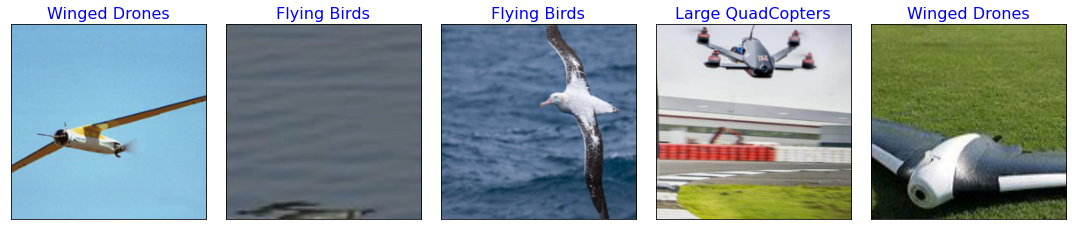

In [6]:
data.show_batch(save_as="sample.jpg")

# 4. Training Mobilenet Model - Only last layers
Modified last layer from 1000 classes to 4 and make only last layer trainable.
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [8]:
import torch.optim as optim
#from torch_lr_finder import LRFinder

model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_ft.classifier[1] = nn.Linear(1280, 4)
model_ft = model_ft.to(device)

Find hyper parameter lr value using LR Finder

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


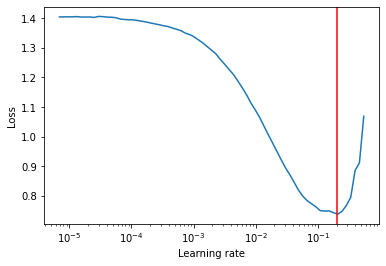

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.classifier[1].parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(data.dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.2) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [11]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.01, momentum=0.09)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.1, 
                                          steps_per_epoch=len(data.dataloaders['train']), #Training folder size/bs 
                                          epochs=25)

In [12]:
model_res, plotData = train_model(model_ft, data, device, criterion, optimizer_ft, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.8177 Acc: 0.7162
val Loss: 0.5078 Acc: 0.8397

Epoch 1/24
----------
train Loss: 0.5355 Acc: 0.8281
val Loss: 0.3854 Acc: 0.8801

Epoch 2/24
----------
train Loss: 0.4732 Acc: 0.8396
val Loss: 0.3473 Acc: 0.8843

Epoch 3/24
----------
train Loss: 0.4415 Acc: 0.8490
val Loss: 0.3213 Acc: 0.8864

Epoch 4/24
----------
train Loss: 0.4211 Acc: 0.8553
val Loss: 0.3070 Acc: 0.8895

Epoch 5/24
----------
train Loss: 0.4095 Acc: 0.8540
val Loss: 0.3032 Acc: 0.8908

Epoch 6/24
----------
train Loss: 0.3993 Acc: 0.8548
val Loss: 0.2918 Acc: 0.8956

Epoch 7/24
----------
train Loss: 0.3956 Acc: 0.8562
val Loss: 0.2839 Acc: 0.8944

Epoch 8/24
----------
train Loss: 0.3877 Acc: 0.8584
val Loss: 0.2798 Acc: 0.8952

Epoch 9/24
----------
train Loss: 0.3808 Acc: 0.8653
val Loss: 0.2801 Acc: 0.8969

Epoch 10/24
----------
train Loss: 0.3685 Acc: 0.8640
val Loss: 0.2760 Acc: 0.8975

Epoch 11/24
----------
train Loss: 0.3741 Acc: 0.8626
val Loss: 0.2702 Acc: 0.8973

Epoch 12/24
----------
t

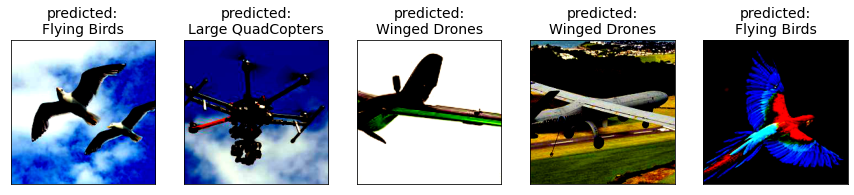

In [13]:
visualize_model(model_res, data, device,"visualize_1.jpg")

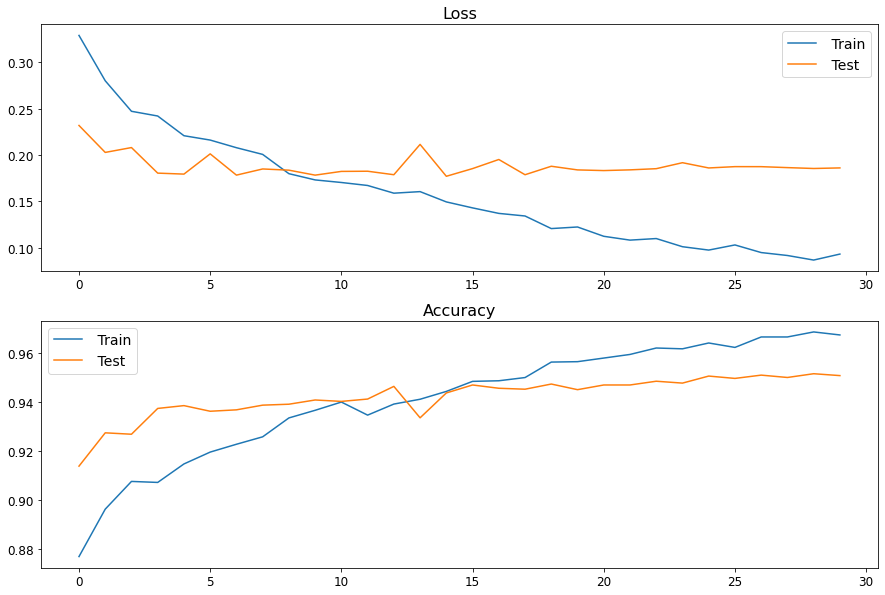

In [29]:
PlotGraph(plotData,"loss_accuracy_1.jpg")

#6. Finetuning the Model by Training all layers
Load a trained model and unfreeze all the layers. Train again to improve the accuracy. 

In [15]:
model_conv = model_res
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_conv = model_conv.to(device)

for param in model_conv.parameters():
    param.requires_grad = True

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


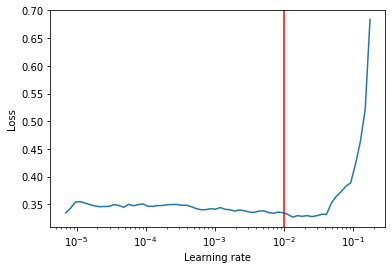

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(data.dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.01) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [17]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# One Cycle Policy
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_conv,
                                          max_lr=0.01, 
                                          steps_per_epoch=len(data.dataloaders['train']), #Training folder size/bs
                                          epochs=30,pct_start=0.2, div_factor=10, final_div_factor=100)

In [18]:
model_final, plotData = train_model(model_conv, data, device, criterion, optimizer_conv, scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 0.3291 Acc: 0.8769
val Loss: 0.2319 Acc: 0.9138

Epoch 1/29
----------
train Loss: 0.2802 Acc: 0.8962
val Loss: 0.2029 Acc: 0.9273

Epoch 2/29
----------
train Loss: 0.2472 Acc: 0.9075
val Loss: 0.2081 Acc: 0.9268

Epoch 3/29
----------
train Loss: 0.2421 Acc: 0.9071
val Loss: 0.1805 Acc: 0.9373

Epoch 4/29
----------
train Loss: 0.2209 Acc: 0.9146
val Loss: 0.1795 Acc: 0.9384

Epoch 5/29
----------
train Loss: 0.2162 Acc: 0.9195
val Loss: 0.2013 Acc: 0.9361

Epoch 6/29
----------
train Loss: 0.2080 Acc: 0.9227
val Loss: 0.1784 Acc: 0.9367

Epoch 7/29
----------
train Loss: 0.2007 Acc: 0.9257
val Loss: 0.1850 Acc: 0.9386

Epoch 8/29
----------
train Loss: 0.1799 Acc: 0.9334
val Loss: 0.1837 Acc: 0.9390

Epoch 9/29
----------
train Loss: 0.1732 Acc: 0.9365
val Loss: 0.1784 Acc: 0.9407

Epoch 10/29
----------
train Loss: 0.1704 Acc: 0.9399
val Loss: 0.1824 Acc: 0.9401

Epoch 11/29
----------
train Loss: 0.1672 Acc: 0.9345
val Loss: 0.1826 Acc: 0.9411

Ep

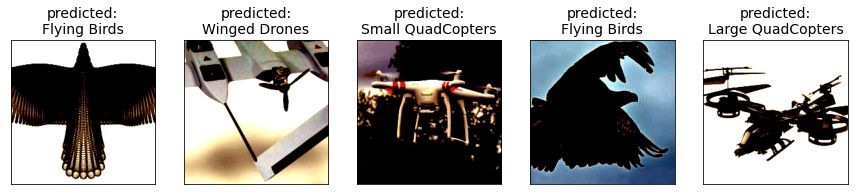

In [20]:
visualize_model(model_res, data, device,"visualize_2.jpg")
plt.ioff()
plt.show()

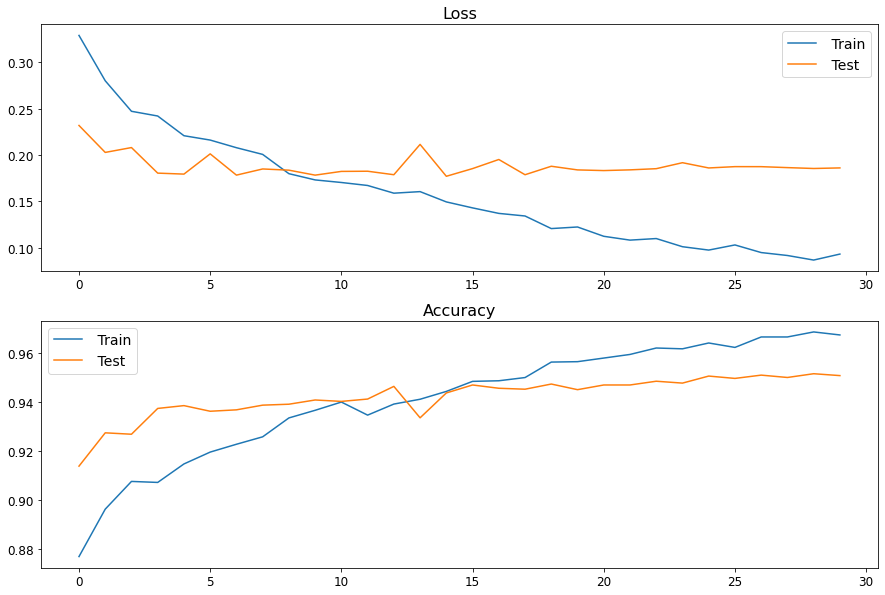

In [28]:
PlotGraph(plotData,"loss_accuracy_2.jpg")

# 7. Plotting Misclassified images

Miss-Classified Images in Flying Birds


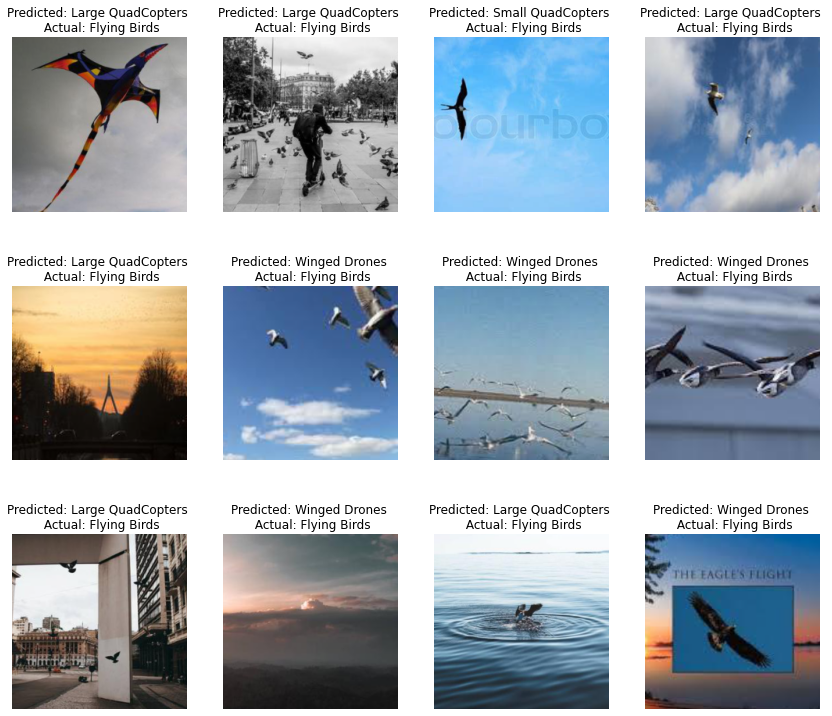

In [27]:
print("Miss-Classified Images in Flying Birds")
ShowMissclassifiedImages(model_final, data,0, device,save_as="MisclassifiedFlyingBirds.jpg")

Miss-Classified Images in Large Quadcopters


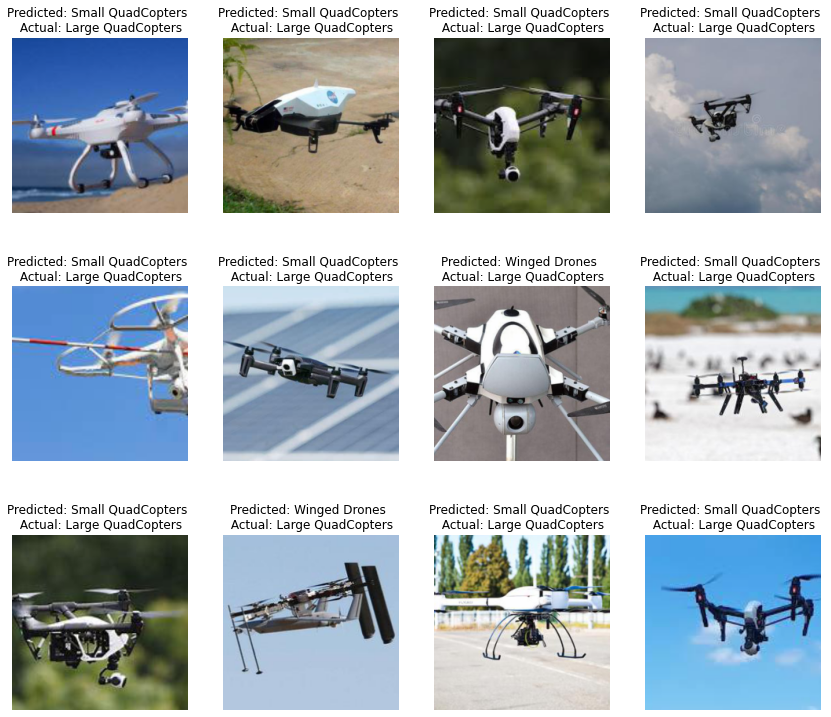

In [24]:
print("Miss-Classified Images in Large Quadcopters")
ShowMissclassifiedImages(model_final, data,1, device,save_as="MisclassifiedLargeQuadcopter.jpg")

Miss-Classified Images in Small Quadcopters


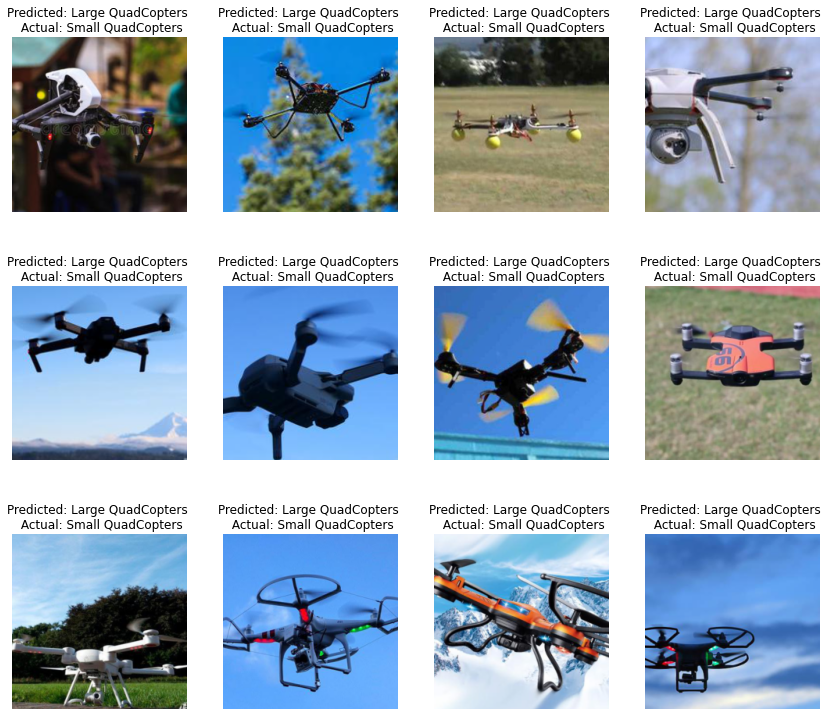

In [25]:
print("Miss-Classified Images in Small Quadcopters")
ShowMissclassifiedImages(model_final, data,2, device,save_as="MisclassifiedSmallQuadcopter.jpg")

Miss-Classified Images in Winged Drones


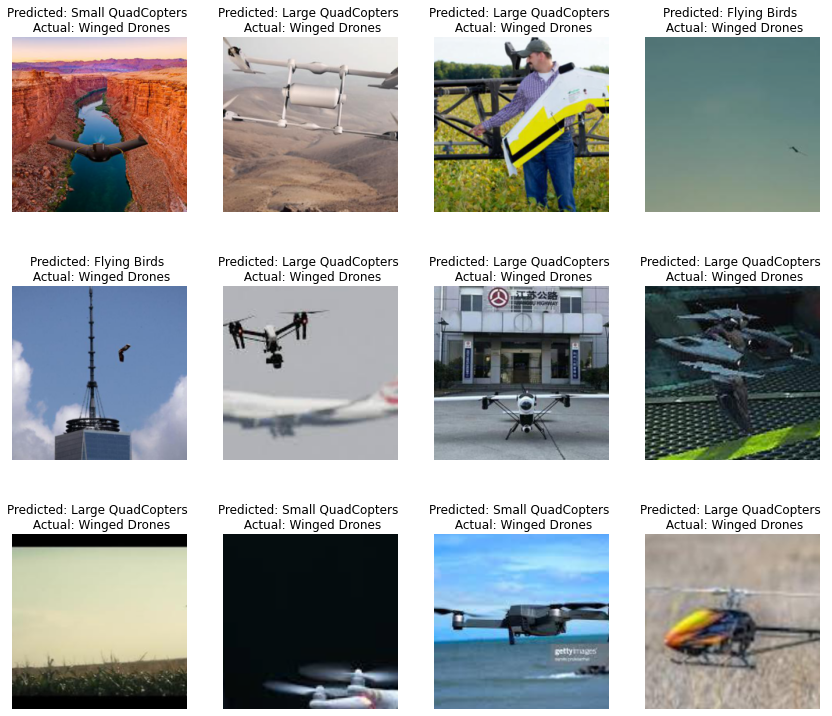

In [26]:
print("Miss-Classified Images in Winged Drones")
ShowMissclassifiedImages(model_final, data,3, device,save_as="MisclassifiedWingedDrones.jpg")

# 8. Saving Model

In [ ]:
# Save GPU Model
torch.save(model_final.state_dict(), '/content/mobilenet_v2_custom_trained_gpu_v6.pt')

# Load CPU Model
device = torch.device('cpu')
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(1280, 4)
model.load_state_dict(torch.load('/content/mobilenet_v2_custom_trained_gpu_v6.pt',
                                 map_location=device))

# Saving Trace Model
model.eval()
# trace model with a dummy input
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
traced_model.save('mobilenet_v2_custom_trained_v6.pt')